In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio
from sklearn.metrics import average_precision_score
import seaborn as sns
from tqdm import tqdm

In [99]:
#dataset = "de_novo_v1"
#dataset = "de_novo_v2"
dataset = "de_novo_v3/3_prime_UTR_variant/9"

models = [
    "gpnmsa",
    #"CADD_RawScore",
    "phyloP-100v",
    "phyloP-241m",
    "phastCons-43p",
]

model_renaming = {
    "gpnmsa": "GPN-MSA",
    "CADD_RawScore": "CADD",
}

V = pl.read_parquet(f"../../results/dataset/{dataset}/test.parquet")
for model in models:
    V = V.with_columns(
        pl.read_parquet(f"../../results/dataset/{dataset}/features/{model}.parquet")["score"].alias(model_renaming.get(model, model))
    )
models = [model_renaming.get(model, model) for model in models]
V

label,chrom,pos,ref,alt,consequence,trait,AF,GPN-MSA,phyloP-100v,phyloP-241m,phastCons-43p
bool,str,i64,str,str,str,str,f64,f32,f64,f64,f64
false,"""21""",43695258,"""A""","""T""","""3_prime_UTR_variant""",null,null,1.56,-0.529,-1.378,0.0
false,"""21""",34403443,"""A""","""C""","""3_prime_UTR_variant""",null,null,-0.06,0.24,0.37,0.01
false,"""21""",43984448,"""G""","""T""","""3_prime_UTR_variant""",null,null,-0.23,-0.401,-0.281,0.001
false,"""21""",46300749,"""A""","""T""","""3_prime_UTR_variant""",null,null,1.46,0.189,-0.078,0.005
false,"""21""",36751530,"""T""","""A""","""3_prime_UTR_variant""",null,null,1.18,-0.653,-1.001,0.0
…,…,…,…,…,…,…,…,…,…,…,…
true,"""16""",173694,"""A""","""G""","""3_prime_UTR_variant""","""Alpha Thalassaemia""",null,5.49,1.563,4.742,0.01
true,"""X""",71107428,"""T""","""C""","""3_prime_UTR_variant""","""Immunodeficiency, severe combi…",null,5.51,2.227,5.164,0.992
true,"""X""",48824894,"""A""","""T""","""3_prime_UTR_variant""","""Chondrodysplasia""",null,3.86,0.802,0.471,0.01


In [100]:
# TODO: should be careful about setting nan = 0 for conservation models
V.group_by("label").agg(pl.mean(models))

label,GPN-MSA,phyloP-100v,phyloP-241m,phastCons-43p
bool,f32,f64,f64,f64
true,4.658913,1.450326,3.192152,0.657217
false,1.885845,0.017993,0.043633,0.233034


In [101]:
def odds_ratio_score(y_true, y_pred, threshold_q=0.05):
    df = pl.DataFrame({"label": y_true, "score": -y_pred})
    threshold = df.select(pl.col("score").quantile(threshold_q))["score"]
    # TODO: need to decide how to handle ties... they are certainly an issue with phastCons
    #if threshold_q == 0.05:
    #    print((df["score"] <= threshold).sum())
    group_counts = (
        df.group_by(["label", pl.col("score") <= threshold]).len()
        .sort(["label", "score"])["len"].to_numpy().reshape((2,2))
    )
    #if threshold_q == 0.05:
    #    print(group_counts)
    res = odds_ratio(group_counts, kind="sample")
    ci = res.confidence_interval(confidence_level=0.95)
    return res.statistic, ci.low, ci.high

In [102]:
or_pcts = [
    #1,
    #2,
    5,
    10,
]

or_pct_cols = [f"OR@{or_pct}" for or_pct in or_pcts]

res = []
for model in tqdm(models):
    y_true = V["label"]
    y_pred = V[model]
    res.append((
        model,
        average_precision_score(y_true, y_pred),
        *[odds_ratio_score(y_true, y_pred, or_pct / 100) for or_pct in or_pcts]
    ))
res = pd.DataFrame(res, columns=["model", "AUPRC"] + or_pct_cols)
res

100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


,model,AUPRC,OR@5,OR@10
0,GPN-MSA,0.433810,"(17.675, 7.274731526729315, 42.943938735352354)","(11.025641025641026, 5.4672701748150825, 22.23..."
1,phyloP-100v,0.358206,"(11.823529411764707, 4.936798399416953, 28.317...","(7.503448275862069, 3.7089395051564895, 15.180..."
2,phyloP-241m,0.490674,"(21.774193548387096, 8.821713708037379, 53.744...","(21.21212121212121, 10.306471432531577, 43.657..."
3,phastCons-43p,0.266563,"(5.198412698412699, 2.27408971981485, 11.88321...","(4.136363636363637, 1.999002406928525, 8.55902..."


In [103]:
# Reshape the data from wide to long format for plotting using pandas.melt
res_long = res.melt(
    id_vars="model",
    value_vars=or_pct_cols,
    var_name="%",
    value_name="OR_CI",
)

# Extract OR and CI values into separate columns
# The .str accessor provides an efficient way to split tuples in a Series
res_long['OR'] = res_long['OR_CI'].str[0]
res_long['ci_low'] = res_long['OR_CI'].str[1]
res_long['ci_high'] = res_long['OR_CI'].str[2]
res_long

,model,%,OR_CI,OR,ci_low,ci_high
0,GPN-MSA,OR@5,"(17.675, 7.274731526729315, 42.943938735352354)",17.675000,7.274732,42.943939
1,phyloP-100v,OR@5,"(11.823529411764707, 4.936798399416953, 28.317...",11.823529,4.936798,28.317107
2,phyloP-241m,OR@5,"(21.774193548387096, 8.821713708037379, 53.744...",21.774194,8.821714,53.744150
3,phastCons-43p,OR@5,"(5.198412698412699, 2.27408971981485, 11.88321...",5.198413,2.274090,11.883214
4,GPN-MSA,OR@10,"(11.025641025641026, 5.4672701748150825, 22.23...",11.025641,5.467270,22.235001
5,phyloP-100v,OR@10,"(7.503448275862069, 3.7089395051564895, 15.180...",7.503448,3.708940,15.180009
6,phyloP-241m,OR@10,"(21.21212121212121, 10.306471432531577, 43.657...",21.212121,10.306471,43.657433
7,phastCons-43p,OR@10,"(4.136363636363637, 1.999002406928525, 8.55902...",4.136364,1.999002,8.559021


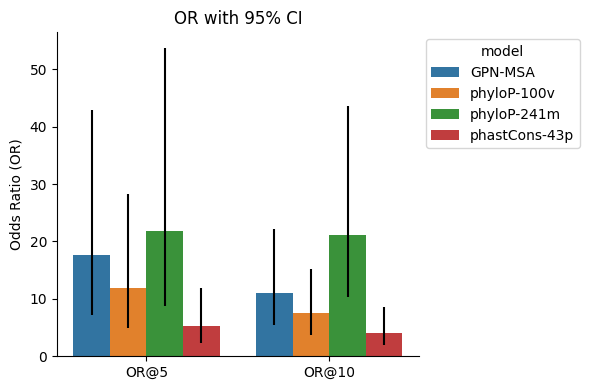

In [104]:
# 1. Create the bar plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=res_long, x="%", y="OR", hue="model")

# 2. Add custom error bars robustly
for bar in ax.patches:
    # --- THIS IS THE FIX ---
    # Ignore invisible "ghost" patches that seaborn sometimes creates
    if bar.get_height() == 0 and bar.get_width() == 0:
        continue

    # Get the bar's color to identify its hue
    bar_color = bar.get_facecolor()

    # Get the x-tick label for the bar
    x_tick_index = int(round(bar.get_x() + bar.get_width() / 2))
    x_tick_label = ax.get_xticklabels()[x_tick_index].get_text()

    # Get the handles for the legend
    legend_handles, _ = ax.get_legend_handles_labels()

    hue_label = ""
    for handle in legend_handles:
        # Use the .patches[0] version for robustness across matplotlib versions
        if handle.get_facecolor() == bar_color:
            hue_label = handle.get_label()
            break

    # Find the corresponding data row in the DataFrame
    data_row = res_long[(res_long['model'] == hue_label) & (res_long['%'] == x_tick_label)]

    if data_row.empty:
        continue

    # Extract data from the correctly identified row
    ci_low = data_row['ci_low'].iloc[0]
    ci_high = data_row['ci_high'].iloc[0]

    # Use the bar's actual height for y-position and calculation
    bar_height = bar.get_height()

    # Calculate error bar magnitudes
    lower_error = bar_height - ci_low
    upper_error = ci_high - bar_height

    # Ensure errors are positive
    if lower_error < 0: lower_error = 0
    if upper_error < 0: upper_error = 0

    # Get the x-coordinate for the error bar
    x_coord = bar.get_x() + bar.get_width() / 2

    # Plot the correctly aligned error bar
    ax.errorbar(x=x_coord, y=bar_height, yerr=[[lower_error], [upper_error]],
                fmt='none',
                c='black')

# --- Final Touches ---
# Use ax.set_ylim() for setting y-axis limits
ax.set_ylim(bottom=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("OR with 95% CI")
ax.set_ylabel("Odds Ratio (OR)")
ax.set_xlabel("")
sns.despine()
plt.tight_layout()
plt.show()